Ya hemos realizado un análisis exploratorio durante la primera parte del trabajo práctico. En este notebook se volverá a retomar dicho análisis para lograr conseguir un *preprocesamiento* de datos con mayor calidad de tal forma que nuestros modelos de aprendizaje automático que aplicaremos, puedan aprender mejor sobre el conjunto de datos a presentarles. Ademas no queremos que nos devuelvan basura. Tal como dice el refrán:

"**Garbage in... garbage out**"

Profundizaremos en diferentes técnicas de la *Ingeniería de Features* que no hemos tratado en la primera parte del trabajo práctico y nos será de muchísima utilidad para la hora de exportar nuestros preprocesamientos en el fichero **preprocessing.py** solicitado. 

In [1]:
from functools import lru_cache
import dtreeviz.trees as dtreeviz
import graphviz
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import ipywidgets as widgets
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import pandas as pd
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import StratifiedShuffleSplit, KFold, StratifiedKFold
sns.set()

from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import graficar_matriz_confusion
from preprocessing import conversion_numerica

In [ ]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)


# Obtengo ya dataset numérico, preparado

In [ ]:

#En el markdown hablar de 'stratify', más que tenemos ~75% de personas con bajo valor.
X_df, X_holdout_split, y_df, y_holdout_split = train_test_split(
    X_df_r, y_df_r, random_state=10, test_size=0.20, stratify=y_df_r
)

labels = 'Bajo valor', 'Alto valor'
explode = (0, 0.1)  

fig1, (ax1, ax2) = plt.subplots(1, 2, dpi=110)
ax1.pie(pd.DataFrame(y_df)[0].value_counts(normalize=True), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Train split')

ax2.pie(pd.DataFrame(y_holdout_split)[0].value_counts(normalize=True), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Test split')

plt.show()

# Buscando reducir dimensionalidad con método de selección vistos (RFE)

ESTO ES DEMASIADO IMPORTANTE PARA CHARLAR!

In [ ]:
selector = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
selector = selector.fit(X_df_scaled, y_df)


f = selector.get_support(1) 
X_reduced = X_df_scaled[X_df_scaled.columns[f]] 
display(X_reduced.shape)
display(X_reduced.info())
X_reduced

# JAJA que onda ésta cosa de RFECV

In [ ]:
# automatically select the number of features for RFE

from sklearn.feature_selection import RFECV


selector = RFECV(estimator=DecisionTreeClassifier())
selector = selector.fit(X_df_scaled, y_df)


f = selector.get_support(1) 
X_reduced = X_df_scaled[X_df_scaled.columns[f]] 
display(X_reduced.shape)
X_reduced

# Aplico RFECV con lo obtenido en '#1 - Arbol de Decision.ipynb'

In [ ]:
from sklearn.feature_selection import RFECV

#clf = DecisionTreeClassifier(criterion = 'gini', max_depth= 3, min_samples_leaf = 535, random_state=10)
clf = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 535, random_state=10)
selector = RFECV(
    estimator=clf,
    #min_features_to_select=10,
    step=10,
    n_jobs=-1,
    scoring="f1",
    cv=10,
)
selector = selector.fit(X_df_scaled, y_df)

f = selector.get_support(1) 
X_reduced = X_df_scaled[X_df_scaled.columns[f]] 
display(X_reduced.shape)
display(X_reduced.info())
X_reduced


# RFECV full power (no recuerdo de dónde saqué este codigo)

In [ ]:
# automatically select the number of features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = X_df_scaled, y_df
# create pipeline
rfe = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# Matriz de correlación, para todo numérico pero falta la variable target graficar, ojo...

In [ ]:
plt.figure(figsize=(12,10))
cor = X_reduced.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Buscando clusters

## Busquemos reducir dimensionalidad con algún escalado de los datos

Definamos la siguiente función que reduzca la dimensionalidad. Utilzaremos TruncatedSVD para reducir lo mismo el cual realiza una reducción via la descomposición de valores singulares.

**Chamuyar más sobre TruncatedSVD**

Pero antes de reducir la dimensionalidad, apliquemos diferentes escalado de los datos para saber cual reducción nos mantiene un mayor porcentaje de varianza.

In [3]:
def graficar_reducciones_con_preprocesamientos(df):
    scalers = [
        StandardScaler(),
        MinMaxScaler(),  
        RobustScaler(), 
        PowerTransformer(), 
        Normalizer(),
    ]

    fig, ax = plt.subplots(dpi=110)
    for count, scaler in enumerate(scalers):
        print("----------------------------------------------------------------------------")
        print("Buscando reducción de dimensionalidad con preprocesamiento de", scaler)

        scaled = scaler.fit_transform(df)
        X_df_scaled = pd.DataFrame(scaled, index=df.index, columns=df.columns)
        
        svd = TruncatedSVD(n_components=df.shape[1]-1, n_iter=7, random_state=10)
        svd.fit(X_df_scaled)

        var_cumu = np.cumsum(svd.explained_variance_ratio_) * 100
        k = np.argmax(var_cumu > 95)
        
        print("El numero minimo de componentes para explicar el 95% de la varianza es: " + str(k))
        if count == 4:
            print("----------------------------------------------------------------------------\n")

        ax.set_title('Varianza acumulada explicada por componente')
        ax.set_ylabel('Varianza acumulada explicada')
        ax.set_xlabel('Componentes principales')
    
        axes = ax.plot(var_cumu, label = scaler)
        ax.legend()
        ax.axhline(y=95, color="r", linestyle="--")


----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de StandardScaler()
El numero minimo de componentes para explicar el 95% de la varianza es: 31
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de MinMaxScaler()
El numero minimo de componentes para explicar el 95% de la varianza es: 22
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de RobustScaler()
El numero minimo de componentes para explicar el 95% de la varianza es: 0
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de PowerTransformer()
El numero minimo de componentes para explicar el 95% de la varianza es: 31
----------------------------------------------------------------------------
Bu

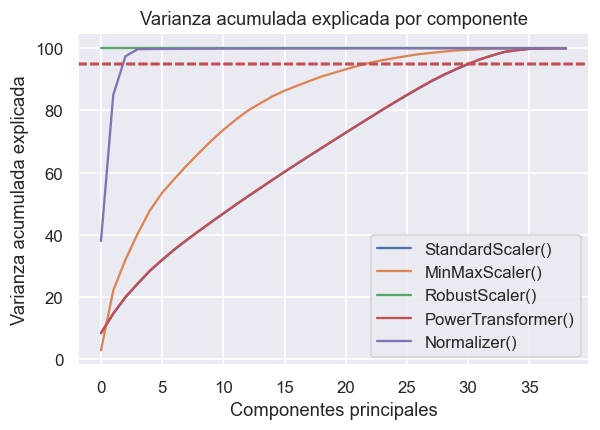

In [4]:
X_df_numerico = conversion_numerica(X_df_r) 
graficar_reducciones_con_preprocesamientos(X_df_numerico)

Aquella transformación con la que logramos mantener un 95% de varianza es la MinMaxScaler() con un numero de componentes menor, de 22. 

Tiene sentido que con al Normalizer() hayamos obtenido solamente 2 componentes pues estan todos los valores normalizado. Si se piensa en un grafico 2D es como si se proyectase ese circulo unitario (formado gracias a una Normalización) sobre los ejes en 2 dimensiones, es decir, sobre 2 componentes principales de los ejes.


Nos quedaremos entonces con el escalado de los datos de *MinMaxScaler()* aplicando TruncatedSVD con 22 compoenntes a reducir.

In [5]:
scaled = MinMaxScaler().fit_transform(X_df_numerico)
X_df_numerico_scaled = pd.DataFrame(scaled, index=X_df_numerico.index, columns=X_df_numerico.columns)

svd = TruncatedSVD(n_components=22, n_iter=7, random_state=10)
X_df_numerico_scaled_svd = pd.DataFrame(svd.fit_transform(X_df_numerico_scaled))

El cual podemos comprobar sus 22 componetes: 

In [6]:
X_df_numerico_scaled_svd.shape

(32561, 22)

## Ahora encontremos los clusters con dataset reducido

In [7]:
def obtener_mejor_hiperparametros_dbscan(df, min_samples_parameters, eps_parameters):
    """
        Lo comun:     
    * min_samples_parameters = [3,4,5,6,7,8]
    * eps_parameters = [0.1, 0.2, 0.3, 0.4]

    * df['cluster_dbscan'] = DBSCAN(algorithm='kd_tree', eps= 0.4, min_samples = 3).fit_predict(pca_result)

    """

    print("----------------------------------------------------------------------------")
    parameter_grid = ParameterGrid({'eps': eps_parameters, 'min_samples': min_samples_parameters})

    best_score = -1
    best_n_clusters = -1
    dbscan = DBSCAN(algorithm='kd_tree')    
    silhouette_scores = []

    for p in parameter_grid:
        dbscan.set_params(**p)
        dbscan.fit(df)

        ss = silhouette_score(df, dbscan.labels_)
        silhouette_scores += [ss]

        print('Parametros', p, 'Coeficiente Silhouette', ss)

        if ss > best_score:
            best_score = ss
            best_grid = p
            best_n_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)

    print("----------------------------------------------------------------------------")
    return best_grid, best_n_clusters

In [8]:
best_grid, n_clusters = obtener_mejor_hiperparametros_dbscan(X_df_numerico_scaled_svd, [3,4,5,6,7,8], [0.1, 0.2, 0.3, 0.4])
best_grid, n_clusters

----------------------------------------------------------------------------
Parametros {'eps': 0.1, 'min_samples': 3} Coeficiente Silhouette 0.5138582974207861
Parametros {'eps': 0.1, 'min_samples': 4} Coeficiente Silhouette 0.5068163947408373
Parametros {'eps': 0.1, 'min_samples': 5} Coeficiente Silhouette 0.47473736954132795
Parametros {'eps': 0.1, 'min_samples': 6} Coeficiente Silhouette 0.4734253895892027
Parametros {'eps': 0.1, 'min_samples': 7} Coeficiente Silhouette 0.46161510561225166
Parametros {'eps': 0.1, 'min_samples': 8} Coeficiente Silhouette 0.44863799962962975
Parametros {'eps': 0.2, 'min_samples': 3} Coeficiente Silhouette 0.696850444717989
Parametros {'eps': 0.2, 'min_samples': 4} Coeficiente Silhouette 0.6807739356022747
Parametros {'eps': 0.2, 'min_samples': 5} Coeficiente Silhouette 0.6623535645956056
Parametros {'eps': 0.2, 'min_samples': 6} Coeficiente Silhouette 0.6436948041469769
Parametros {'eps': 0.2, 'min_samples': 7} Coeficiente Silhouette 0.63079331633557

({'eps': 0.3, 'min_samples': 3}, 955)

## Apliquemos OneHotEncoding para estas clusters

In [9]:
def one_hot_clusters_dbscan(df, eps, min_samples):
    model = DBSCAN(algorithm='kd_tree', eps=eps, min_samples=min_samples)
    df = pd.DataFrame(df)
    df['cluster_dbscan'] = model.fit_predict(df)
    df = pd.get_dummies(df, drop_first=True, columns=['cluster_dbscan'])
    return df

In [10]:
X_df_numerico_scaled_svd_oe = one_hot_clusters_dbscan(X_df_numerico_scaled_svd, 0.3, 3)

In [11]:
X_df_numerico_scaled_svd_oe

,0,1,2,3,4,5,6,7,8,9,...,cluster_dbscan_945,cluster_dbscan_946,cluster_dbscan_947,cluster_dbscan_948,cluster_dbscan_949,cluster_dbscan_950,cluster_dbscan_951,cluster_dbscan_952,cluster_dbscan_953,cluster_dbscan_954
0,1.752113,0.640337,1.024296,-0.805464,-0.204605,0.188264,-0.206560,0.465362,-0.362141,-0.769924,...,0,0,0,0,0,0,0,0,0,0
1,1.615360,-0.990195,0.520318,-0.305737,0.121621,-0.147826,0.862423,0.298176,0.148805,0.237301,...,0,0,0,0,0,0,0,0,0,0
2,1.714770,0.229107,-0.196949,-0.218247,-0.863797,-0.082856,-0.042084,-0.069913,-0.166557,-0.017494,...,0,0,0,0,0,0,0,0,0,0
3,1.299977,-0.545292,-0.529948,0.528548,0.020940,1.076227,0.078454,0.056160,0.096468,-0.175076,...,0,0,0,0,0,0,0,0,0,0
4,1.742162,-0.213598,0.097104,1.043187,0.218813,1.113561,-0.208711,-0.614524,0.035297,0.067742,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,2.106605,-0.354523,-0.068779,0.619300,0.127642,-0.242142,-0.008822,-0.162735,-0.044719,-0.118303,...,0,0,0,0,0,0,0,0,0,0
32557,1.839800,-0.725920,-0.465751,0.100684,-0.067324,-0.027549,-0.045028,-0.139059,-0.183820,-0.094170,...,0,0,0,0,0,0,0,0,0,0
32558,1.918499,0.434474,0.198064,1.181741,0.086791,-0.668615,-0.315744,0.292558,-0.199315,-0.150084,...,0,0,0,0,0,0,0,0,0,0
32559,1.802272,0.749361,-0.559034,-0.485525,0.699931,-0.145362,-0.145273,0.210205,-0.467999,-0.582200,...,0,0,0,0,0,0,0,0,0,0
